<a href="https://colab.research.google.com/github/solllull/entregasML/blob/main/tp3_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A partir de un conjunto de datos seleccionado por la cátedra [1], se busca poder desarrollar un modelo que sea capaz de detectar el tipo de animal que se encuentra en la foto. Dentro de los datos proporcionados hay dos conjuntos de datos: train y test. Cada uno de ellos cuenta con 4.000 y 1.000 imágenes, respectivamente, de cada tipo. Ejemplo: el conjunto de entrenamiento contiene 4.000 imágenes de perros y 4.000 de gatos.

Aclaración: El conjunto de datos proporcionado es la base para trabajar, puede realizar los ajustes que considere necesarios sobre el conjunto de datos de entrenamiento para favorecer los tiempos de entrenamiento y/o conseguir mejores resultados. **Tener en cuenta que no todas las imágenes tienen las mismas dimensiones.**

Para realizar el proyecto se deben llevar a cabo las siguientes acciones:

1. **Análisis exploratorio sobre el conjunto de datos.** Se debe poder visualizar al menos:
- Volumetría de los datos
- Estructura y tipo de las imágenes
- Distribución de la variable a predecir
2. **Machine Learning**
Creación y entrenamiento de modelos de clasificación utilizando al menos dos tipos de redes neuronales vistas en clase (ej: MLP simple y Convolucional). Presentar los resultados dividiendo los conjuntos de datos en training y testing.

3. **Conclusión**
Desarrollar las conclusiones a las que llegaron a partir de los experimentos, destacando la interpretación de los resultados obtenidos. Dedicar una sección en la que se muestren al menos 2 ejemplos en los que el modelo haya acertado y al menos 2 ejemplos donde haya cometido un error. Presente una posible mejora a desarrollar en un futuro para mejorar el rendimiento del modelo.

**Dejo las anotaciones que hice cuando explicaban el tp:**

Podriamos hacer todas las manipulaciones que querramos sobre el dataset. Copias de imagenes, etc. Con train podemos hacer lo que queramos. No se puede hacer en el de test.

Hacer un analisis exploratorio. Volumetría. Estructura y tipo de las imagenes 
(formatos y dimensiones). Ya que no todas las imagenes tienen el mismo tamaño, se puede hacer un analisis para ver la frecuencia de las dimensiones q hay, para saber a que dimensión llevarla. Se va a tener que fundamentar. Distribución de la variable a predecir.

Conclusiones: desarrollar resultados a los que  llegamos. Interpretándolos, analizando que pasa si ponemos data aumentation o no.
Si probamos con data aumentation y las diversas formas en las que probamos, que queden registrado pq es parte de la experimentación.
Ejemplos donde haya acertado y donde no. 2 y 2 para cada clase.
En base a las pruebas o lo q vamos mirando, proponer algo como posible linea de mejora para seguir laburando y mejorando los resultados.
No se va a tener q hacer, solo dejarlo escrito.
Ejemplo: "el dataset es chico, laburar los datos de tal forma utilizar tal modelo de redes, etc."

In [1]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path
import os

# lib para trabajar con arrays
import numpy as np
import cv2
from PIL import Image

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt
import plotly.express as px

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [2]:
TIPO = "dogs", "cats"
# configurar de acuerdo a dónde bajaron los sets de imágenes
TRAINING_DIR = Path('C:/Users/Sol/Desktop/imagenes_tp3_cv/training_set')
TEST_DIR = Path('C:/Users/Sol/Desktop/imagenes_tp3_cv/test_set')

In [57]:
# algunas configuraciones generales respecto a las imagenes
PICTURE_SIZE = 64
CHANNELS = 'rgb'

INPUT_COLUMNS = []

for color in CHANNELS:
    INPUT_COLUMNS.extend(['%s%i' % (color, i)
                          for i in range(PICTURE_SIZE ** 2)])

In [59]:
def extract_inputs(dataset):
    """
    Extrae del conjunto de datos original solo las 
    columnas que se deben utilizar como entrada. 
    """
    # estandarización rápida y simple: dividir todo por 255 :)

    # si queremos usar MLP básico:
    return dataset[INPUT_COLUMNS].values / 255
    
    # si queremos usar convolucionales:
    #return dataset[INPUT_COLUMNS].values.reshape(len(dataset), PICTURE_SIZE, PICTURE_SIZE, len(CHANNELS)) / 255


def extract_outputs(dataset):
    """
    Extrae del conjunto de datos original solo la 
    columna que se debe utilizar como salida y retorna
    tantas columnas como etiquetas distintas existan.
    Por ejemplo, podríamos pensar que las columnas resultantes
    serían: es_fisa, es_gabi, es_mariano.
    """
    is_tipo_columns = [(dataset.tipo == tipo).values for tipo in TIPO]
    return np.array(is_tipo_columns).T

In [60]:
def add_predictions(dataset):
    """
    Agregamos una columna 'prediction' con el label de la persona predicha.
    Otra columna 'prediction_confidence' con el valor que la red devolvió 
    para esa persona.
    Y una última columna 'correct', que determina si la predicción fue o no
    correcta.
    """
    predictions = model.predict(extract_inputs(dataset))

    for tipo_number, tipo in enumerate(TIPO):
        dataset[tipo] = predictions[:, tipo_number]
    
    dataset['prediction'] = dataset[TIPO].idxmax(axis=1)
    dataset['prediction_confidence'] = dataset[TIPO].max(axis=1)
    dataset['correct'] = dataset.prediction == dataset.tipo

## Distribución de la variable a predecir

Buscamos predecir si, dada una imagen, pertecene a un perro o a un gato. El dataset de train contiene 4000 imágenes de perros y 4000 de gatos. El de test contiene 1000 de cada clase. Por ende, ambos datasets están perfectamente balanceados.

In [3]:
def sample_images(dataset):
    #plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
           # ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(TIPO[np.argmax(labels[i])])
            plt.axis("off")

In [4]:
#así como habíamos hecho, faltaba instalar PIL en el entorno virtual
def getImageDimension(path):
    im = Image.open(path)
    width, height = im.size
    return width, height
#devuelve tamaño imagen del path, podría usarse luego en un for para obtener el de todas las imágenes 
#y después ver la distribución, un diagrama de dispersión, algo de eso

## Análisis de dimensiones de las imágenes

In [5]:
# cats
x = [] # width
y = [] # height
for i in range(1, 4000):
    path = str(Path(TRAINING_DIR)) + "\cats\cat."+ str(i) + ".jpg"
    width, height = getImageDimension(path)
    x.append(width)
    y.append(height)
    #sizes.append((width, height))

fig = px.scatter(x=x, y=y)
fig.show()

In [6]:
# dogs
x = [] # width
y = [] # height
for i in range(1, 4000):
    path = str(Path(TRAINING_DIR)) + "\dogs\dog."+ str(i) + ".jpg"
    width, height = getImageDimension(path)
    x.append(width)
    y.append(height)
    #sizes.append((width, height))

fig = px.scatter(x=x, y=y)
fig.show()

Observando los gráficos de dispersión anteriores, vemos que la distribución de las dimensiones que poseen las imágenes, es bastante dispersa. Por lo tanto, las llevamos a todas a una dimensión de 64 x 64.

In [7]:
train = image_dataset_from_directory(
    TRAINING_DIR,
    labels="inferred",  # adivinar los labels en base al nombre del sub directorio ("ariel", etc)
    label_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    class_names=TIPO,  # para usar el mismo orden en todos lados
    color_mode="rgb",  # queremos trabajar con las imágenes a color
    image_size=(64, 64),  # para que corra más rápido, vamos a achicar las imágenes
    shuffle=True,  # que recorra el set de imágenes en orden aleatorio
    seed=42,  # semilla para que la aleatoriedad sea repetible
)

Found 8005 files belonging to 2 classes.


In [8]:
test = image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="categorical",
    class_names=TIPO,
    color_mode="rgb",
    image_size=(64, 64),
    shuffle=True,
    seed=42,
)

Found 2023 files belonging to 2 classes.


In [9]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(TIPO[np.argmax(labels[i])])
            plt.axis("off")

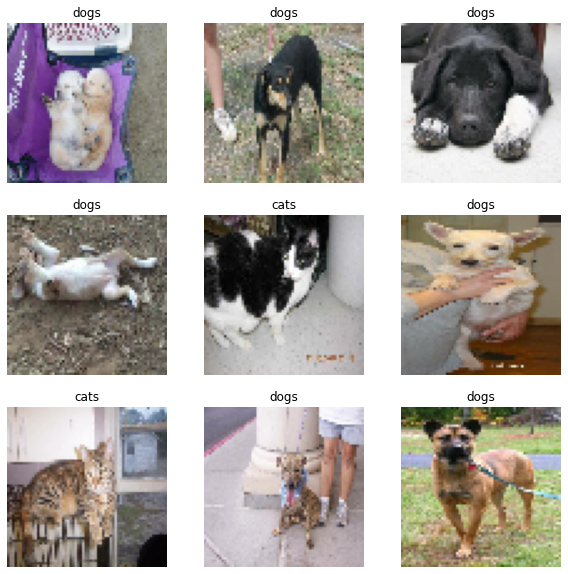

In [10]:
sample_images(train)

## MLP

In [68]:
#este estaria ok
mlp = Sequential([
    # el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
    # usamos una capa de Rescaling para normalizar las entradas de los datasets
    Rescaling(1/255, input_shape=(64, 64, 3)),
    Dense(30, activation='relu'),
    Dropout(0.2),
    Flatten(),
    
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='relu'),
    Dense(20, activation='relu'),
    Dropout(0.1),
    Dense(20, activation='relu'),
    Dense(10, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(len(TIPO), activation='sigmoid'),
])

mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [69]:
mlp.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_15 (Rescaling)     (None, 64, 64, 3)         0         
_________________________________________________________________
dense_149 (Dense)            (None, 64, 64, 30)        120       
_________________________________________________________________
dropout_69 (Dropout)         (None, 64, 64, 30)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 122880)            0         
_________________________________________________________________
dense_150 (Dense)            (None, 10)                1228810   
_________________________________________________________________
dense_151 (Dense)            (None, 10)                110       
_________________________________________________________________
dropout_70 (Dropout)         (None, 10)              

In [70]:
mlp_history = mlp.fit(
    train,
    epochs=10,
    batch_size=128,
    validation_data=test,
)

Epoch 1/10
251/251 [==============================] - 50s 192ms/step - loss: 0.6933 - accuracy: 0.5115 - val_loss: 0.6888 - val_accuracy: 0.5344
Epoch 2/10
251/251 [==============================] - 50s 196ms/step - loss: 0.6804 - accuracy: 0.5567 - val_loss: 0.6599 - val_accuracy: 0.6312
Epoch 3/10
251/251 [==============================] - 51s 199ms/step - loss: 0.6532 - accuracy: 0.6235 - val_loss: 0.6283 - val_accuracy: 0.6520
Epoch 4/10
251/251 [==============================] - 55s 219ms/step - loss: 0.6269 - accuracy: 0.6466 - val_loss: 0.6125 - val_accuracy: 0.6619
Epoch 5/10
251/251 [==============================] - 59s 233ms/step - loss: 0.6187 - accuracy: 0.6605 - val_loss: 0.6195 - val_accuracy: 0.6742
Epoch 6/10
251/251 [==============================] - 54s 212ms/step - loss: 0.5988 - accuracy: 0.6842 - val_loss: 0.6398 - val_accuracy: 0.6589
Epoch 7/10
251/251 [==============================] - 53s 207ms/step - loss: 0.5937 - accuracy: 0.6932 - val_loss: 0.6117 - val_ac

######################### train #########################
accuracy 0.7801374141161774


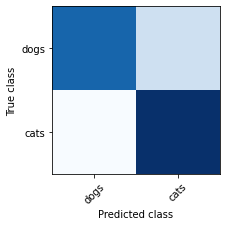

######################### test #########################
accuracy 0.6930301532377657


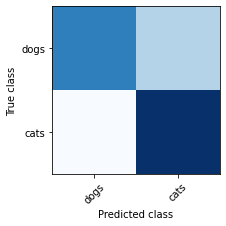

In [71]:
datasets = (
    ("train", train),
    ("test", test),   
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    # el dataset se itera en batches, así que calculams predicciones y labels por cada batch, y luego 
    # concatenamos todo
    batches_predictions = []
    batches_labels =  []
    
    for batch_images, batch_labels in dataset:
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        batches_predictions.append(np.argmax(mlp.predict(batch_images), axis=-1))
        batches_labels.append(np.argmax(batch_labels, axis=-1))

    predictions = np.concatenate(batches_predictions)
    labels = np.concatenate(batches_labels)
    
    print('accuracy', accuracy_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], TIPO, rotation=45)
    plt.yticks([0, 1], TIPO)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

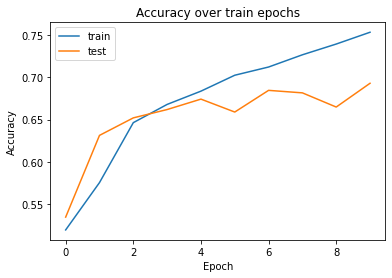

In [72]:
plt.plot(mlp_history.history['accuracy'], label='train')
plt.plot(mlp_history.history['val_accuracy'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Convolución

In [73]:
##este si
cnn = Sequential([
    # el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
    # usamos una capa de Rescaling para normalizar las entradas de los datasets
    Rescaling(1/255, input_shape=(64, 64, 3)),
    
    Convolution2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Convolution2D(filters=64, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Convolution2D(filters=128, kernel_size=(3, 3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    
    Dense(len(TIPO), activation='sigmoid'),
    
])

cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [74]:
cnn.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 128)       

In [76]:
cnn_history = cnn.fit(
    train,
    epochs=5,
    batch_size=128,
    validation_data=test,
)

Epoch 1/5
251/251 [==============================] - 70s 275ms/step - loss: 0.6958 - accuracy: 0.5270 - val_loss: 0.6285 - val_accuracy: 0.6520
Epoch 2/5
251/251 [==============================] - 66s 260ms/step - loss: 0.5949 - accuracy: 0.6775 - val_loss: 0.5361 - val_accuracy: 0.7444
Epoch 3/5
251/251 [==============================] - 74s 293ms/step - loss: 0.5118 - accuracy: 0.7495 - val_loss: 0.5399 - val_accuracy: 0.7291
Epoch 4/5
251/251 [==============================] - 70s 277ms/step - loss: 0.4730 - accuracy: 0.7791 - val_loss: 0.4984 - val_accuracy: 0.7622
Epoch 5/5
251/251 [==============================] - 70s 279ms/step - loss: 0.4342 - accuracy: 0.7934 - val_loss: 0.4726 - val_accuracy: 0.7785


######################### train #########################
accuracy 0.8279825109306683


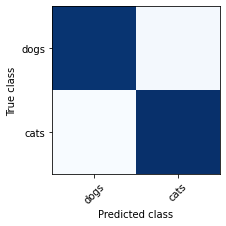

######################### test #########################
accuracy 0.7785467128027682


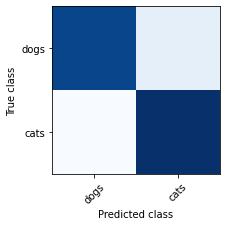

In [77]:
datasets = (
    ("train", train),
    ("test", test),   
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    # el dataset se itera en batches, así que calculams predicciones y labels por cada batch, y luego 
    # concatenamos todo
    batches_predictions = []
    batches_labels =  []
    
    for batch_images, batch_labels in dataset:
        # super importante: usamos argmax para convertir cosas de este formato:
        # [(0, 1, 0), (1, 0, 0), (1, 0, 0), (0, 0, 1)]
        # a este formato (donde tenemos el índice de la clase que tiene número más alto):
        # [1, 0, 0, 2]
        batches_predictions.append(np.argmax(cnn.predict(batch_images), axis=-1))
        batches_labels.append(np.argmax(batch_labels, axis=-1))

    predictions = np.concatenate(batches_predictions)
    labels = np.concatenate(batches_labels)
    
    print('accuracy', accuracy_score(labels, predictions))

    # graficamos la confussion matrix
    plt.figure(figsize=(3, 4))
        
    plt.xticks([0, 1], TIPO, rotation=45)
    plt.yticks([0, 1], TIPO)
    plt.xlabel('Predicted class')
    plt.ylabel('True class')

    plt.imshow(
        confusion_matrix(labels, predictions), 
        cmap=plt.cm.Blues,
        interpolation='nearest',
    )

    plt.show()

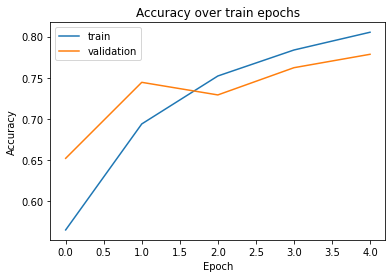

In [78]:
plt.plot(cnn_history.history['accuracy'], label='train')
plt.plot(cnn_history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [79]:
from IPython.display import Image, display


def show_and_predict(image_path):
    image_array = img_to_array(load_img(image_path, target_size=(64, 64)))
    inputs = np.array([image_array])  # armamos un "dataset" con solo esa imagen
    predictions = model.predict(inputs)
    display(Image(image_path, width=500))
    print("Prediction:", TIPO[np.argmax(predictions)])
    print("Prediction detail:", predictions)

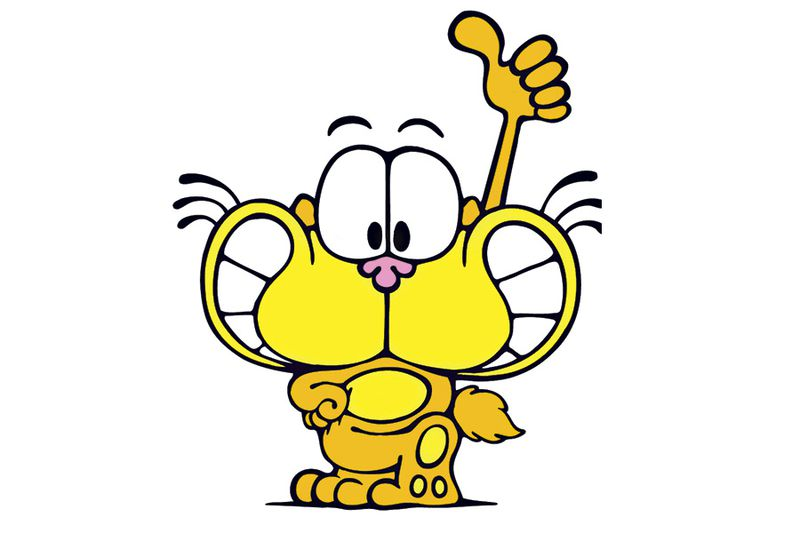

Prediction: cats
Prediction detail: [[0.19724604 0.802754  ]]


In [80]:
show_and_predict("./gaturro.jpg")

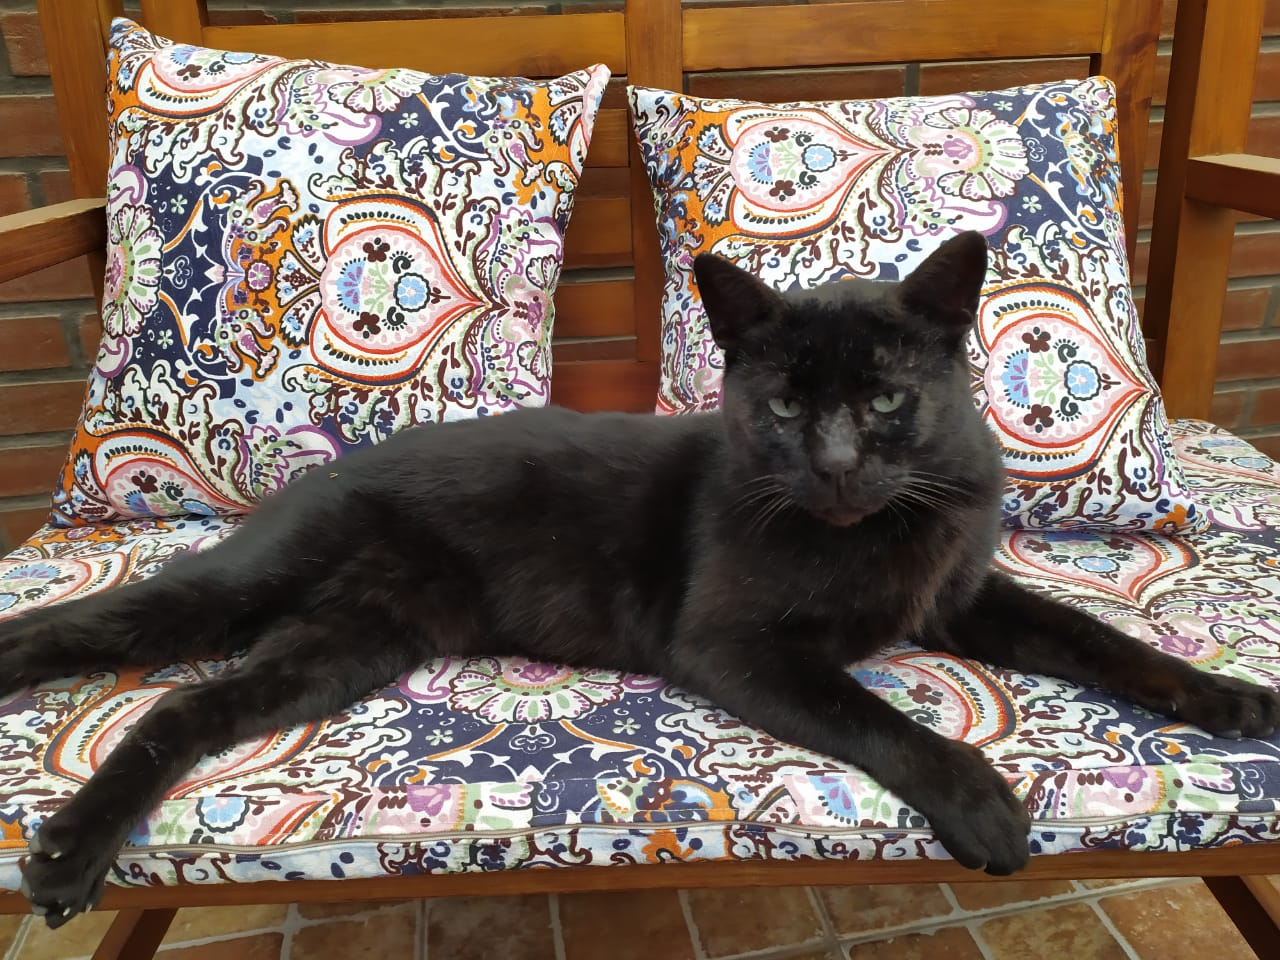

Prediction: dogs
Prediction detail: [[0.63818896 0.36181104]]


In [81]:
show_and_predict("./morcilla.jpeg")

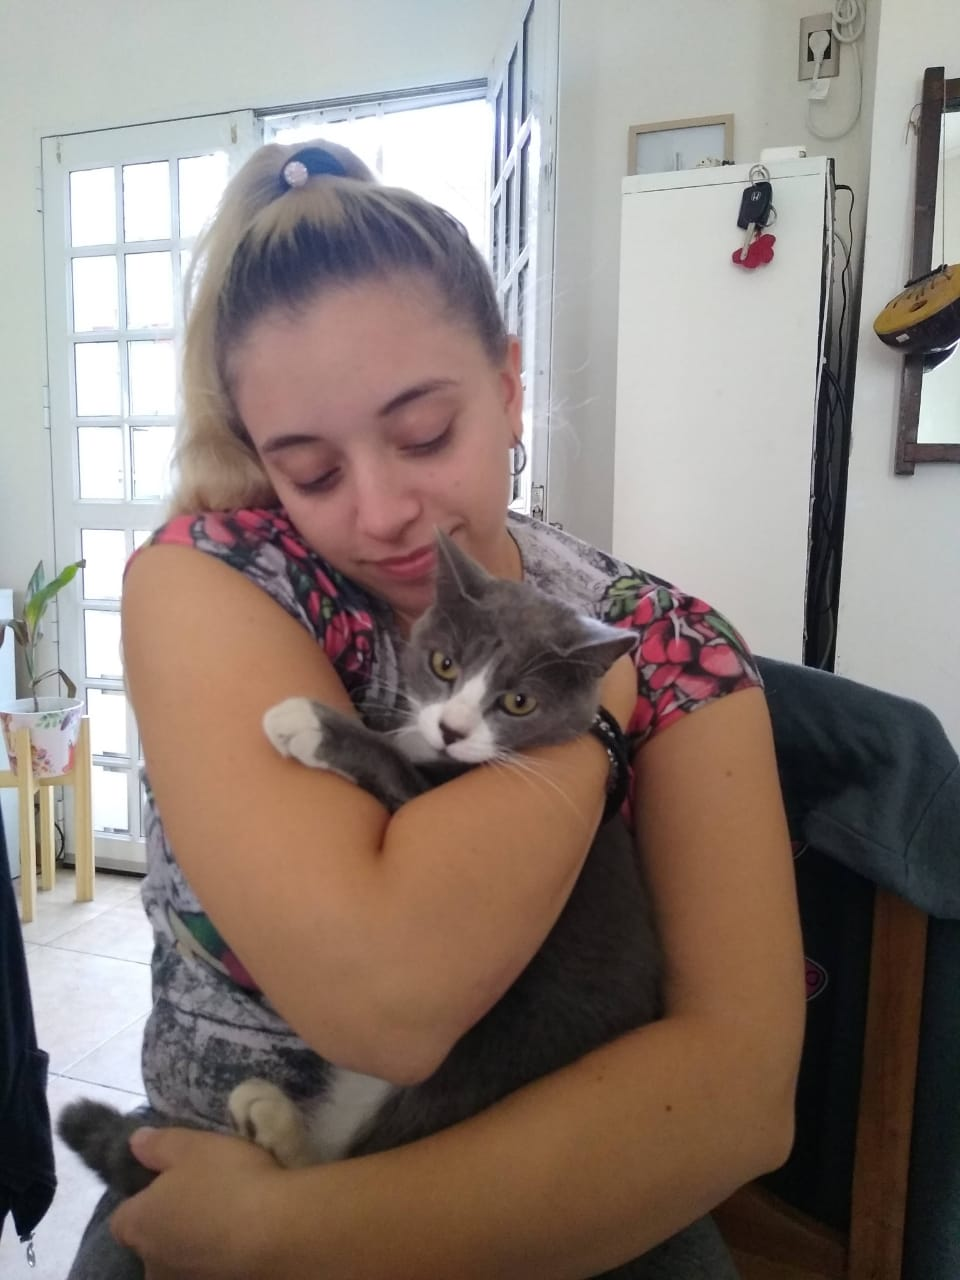

Prediction: cats
Prediction detail: [[0.09065313 0.90934694]]


In [82]:
show_and_predict("./diana.jpeg")

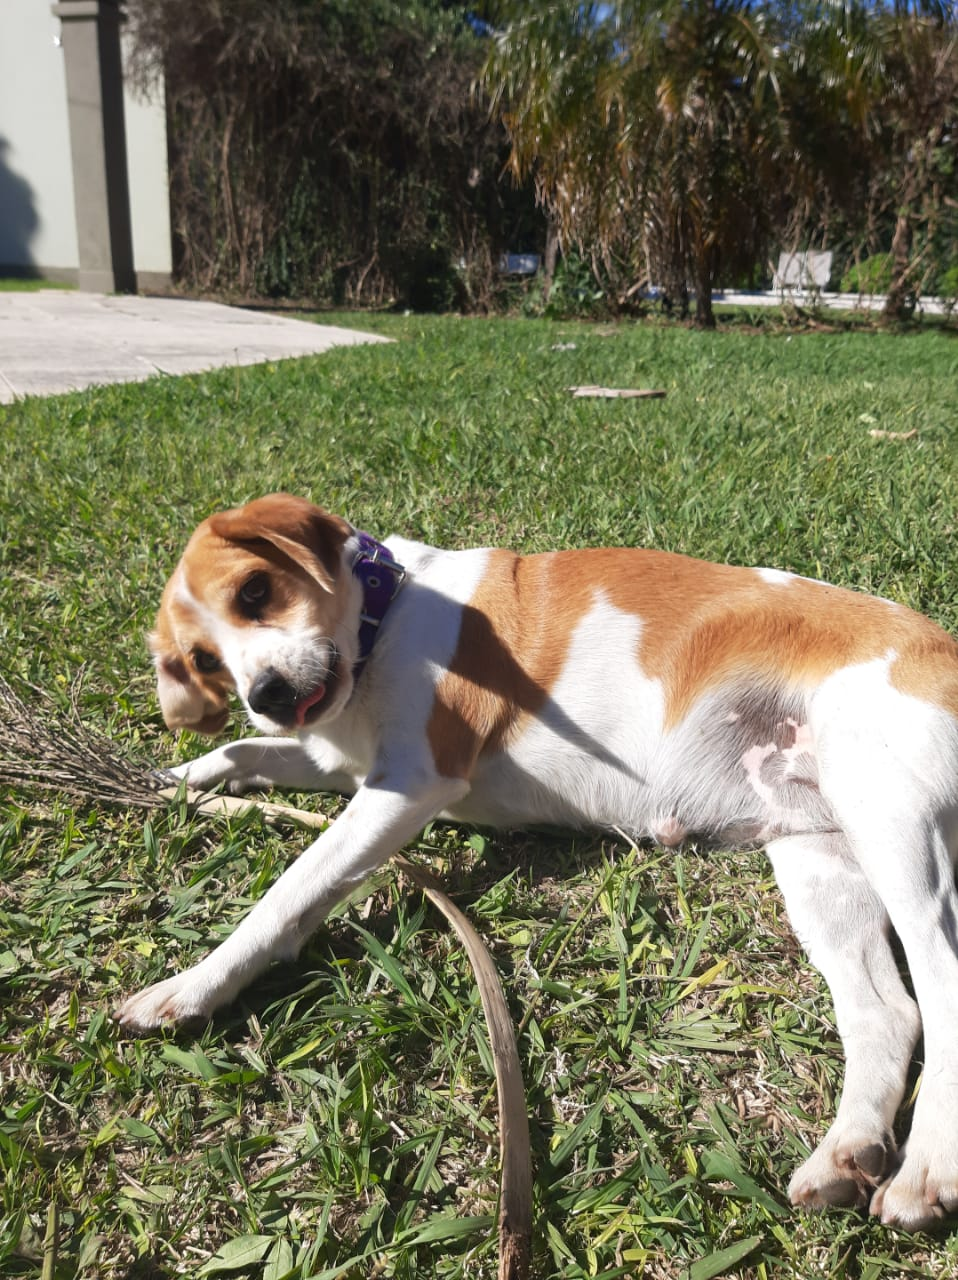

Prediction: cats
Prediction detail: [[0.22907378 0.77092624]]


In [83]:
show_and_predict("./juana.jpeg")

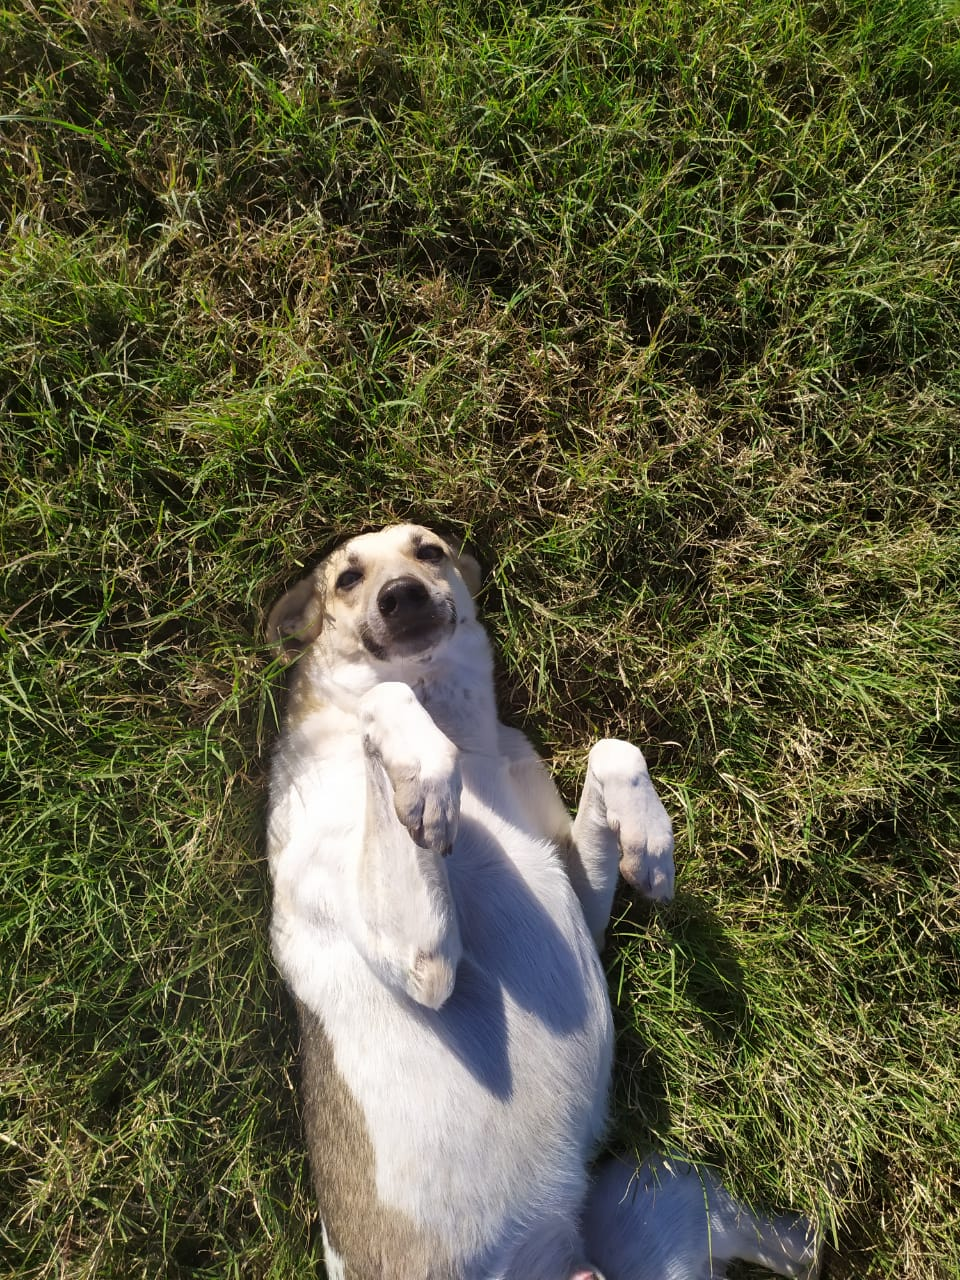

Prediction: dogs
Prediction detail: [[0.8208976  0.17910239]]


In [84]:
show_and_predict("./quito.jpeg")

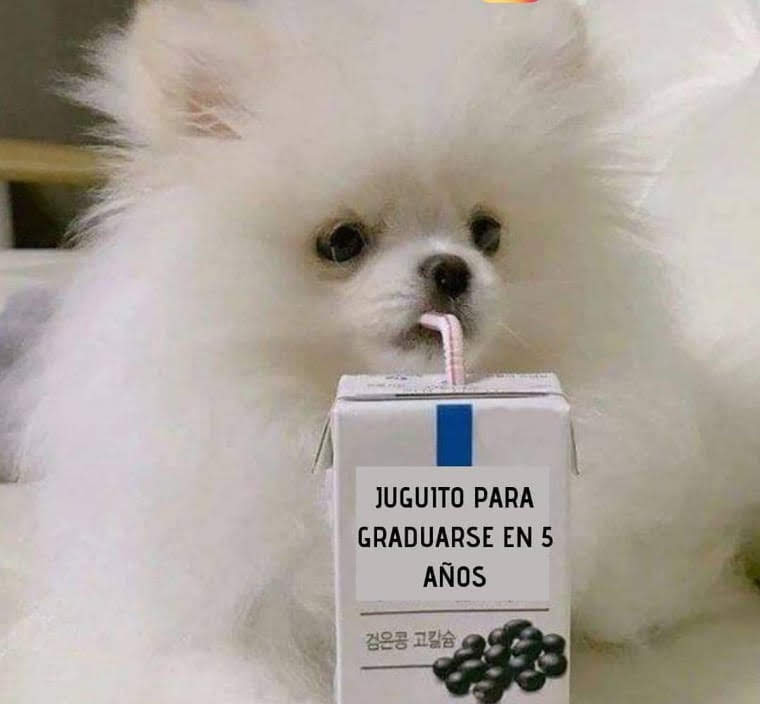

Prediction: dogs
Prediction detail: [[0.5232231  0.47677684]]


In [85]:
show_and_predict("./meme.jpeg")